# Análise dos resultados (V2)

## Importação de módulos

In [2]:
!pip install -q scikit_posthocs

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
import colorcet as cc
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp

O módulo `utils.py` contém definições a respeito das configurações dos experimentos:

In [4]:
%load_ext autoreload
%autoreload 2
import utils

## Coletando resultados

Primeiramente, é necessário coletar os resultados obtidos com os experimentos.
Atualmente, eles estão quase terminados, faltando apenas algumas execuções do SVM+EER para alguns datasets.

In [5]:
def get_results_info(file_list: list) -> pd.DataFrame:
    
    results_info = pd.DataFrame(file_list, columns=["file"])
    results_info[["dataset", "split", "learner", "method"]] = results_info.file.str.split("_", n=3, expand=True)
    results_info['file'] = results_info.file.map(lambda x: os.path.join(utils.RESULTS_V2_PATH, x))
    results_info['method'] = results_info.method.apply(lambda x: x.split('.')[0])
    
    return results_info

In [6]:
def get_results_df(results_info) -> pd.DataFrame:
    df = pd.concat(pd.read_csv(f) for f in  results_info.file)
    
    return df
    

Os resultados estão localizados no diretório `RESULTS_V2_PATH`, importado no módulo `utils.py`

In [7]:
csv_files = !ls  $utils.RESULTS_V2_PATH

Agora podemos pegar as informações a respeito de cada uma das configurações:

In [8]:
results_info = get_results_info(csv_files)
results_info.head()

,file,dataset,split,learner,method
0,../results/v2/abalone-3class_1x5_5NN_borderlin...,abalone-3class,1x5,5NN,borderline_points_sampling
1,../results/v2/abalone-3class_1x5_5NN_class_bal...,abalone-3class,1x5,5NN,class_balance_sampling
2,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likelihood_sampling
3,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likeliood_diff_sampling
4,../results/v2/abalone-3class_1x5_5NN_density_w...,abalone-3class,1x5,5NN,density_weighted_sampling


Agora podemos agregar todos os resultados em um único `DataFrame`

In [9]:
%%time
results_df = get_results_df(results_info)

CPU times: user 18.3 s, sys: 1.52 s, total: 19.9 s
Wall time: 26.9 s


In [10]:
results_df.head()

,time,dataset,classifier,method,run,fold,query,kappa
0,2025-03-23 18:41:24.629248,abalone-3class,5NN,borderline_points_sampling,0,0,0,0.000000
1,2025-03-23 18:41:29.325717,abalone-3class,5NN,borderline_points_sampling,0,0,1,0.231167
2,2025-03-23 18:41:34.087002,abalone-3class,5NN,borderline_points_sampling,0,0,2,0.314495
3,2025-03-23 18:41:38.828586,abalone-3class,5NN,borderline_points_sampling,0,0,3,0.249614
4,2025-03-23 18:41:43.579852,abalone-3class,5NN,borderline_points_sampling,0,0,4,0.212956


## Análise de curvas de aprendizado

Aqui vamos analisar comos os métodos de aprendizado ativo se comportaram para cada par `(learner, dataset)`

In [11]:
# Definindo as cores para os plots:
n_methods = results_info.method.nunique()
color_list = sns.color_palette(cc.glasbey_dark ,n_colors=n_methods)
COLOR_DICT = dict(zip(results_info.method.unique().tolist(), color_list))
COLOR_DICT["random_sampling"] = "firebrick"

In [12]:
def plot_learning_curve(dataset, learner):

    plt.close()
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_ylim(-1,1)
    ax.set_title(f"Average learning curves for AL methods")
    
    
    result_files = results_info[(results_info.learner == learner) & (results_info.dataset == dataset)].file.tolist()

    results_df = pd.concat(pd.read_csv(f) for f in result_files)

    auc_dict = {}
    for method, data in results_df.groupby("method"):
        avg_scores =  data.groupby("query").kappa.mean()
        auc = (np.trapz(avg_scores, avg_scores.index))
        auc_dict[method] = auc

    ranked_method_list = sorted(auc_dict.items(), key=lambda x: x[1],reverse=True)

    i=0
    for method, _ in ranked_method_list:
        avg_curve = results_df[results_df.method == method].groupby("query").kappa.mean()
        ax.plot(avg_curve.rolling(window=5, min_periods=1).mean(),
                utils.get_style(method), linewidth=0.5, color=COLOR_DICT[method], label=utils.ABREV_DICT[method],
            markevery=(0.3, 0.2))
        i+=1
        
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size':8}, framealpha=1)

In [13]:
w.interact(plot_learning_curve,
          dataset=w.SelectionSlider(options=utils.DATASET_LIST),
          learner=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), value="SVC"))

interactive(children=(SelectionSlider(description='dataset', options=('abalone-3class', 'artificial-characters…

<function __main__.plot_learning_curve(dataset, learner)>

## Curvas de Ranking

Primeiro, é necessário calcular o rank de cada query:

In [14]:
def get_avg_ranks(results_df) -> pd.DataFrame:
    # Afere o kappa médio para cada query registrada
    avg_kappa = results_df.groupby(["classifier","method", "query", "dataset"]).kappa.mean()

    # Afere o rank de cada método para cada dataset
    ranks_df = avg_kappa.to_frame(name="kappa")
    ranks_df['rank'] = ranks_df.groupby(["query", "dataset"]).kappa.rank(ascending=False)

    # Calcula rank médio por query para cada 
    avg_ranks = ranks_df.groupby(["classifier", "method", "query"])["rank"].mean()
    return avg_ranks


In [15]:
avg_ranks_df = get_avg_ranks(results_df)

Em seguida, é possível plotar as curvas:

### Curvas de Ranking com Bands

In [16]:
def plot_ranking_curves_with_bands(avg_ranks):

    fig, ax = plt.subplots()
    ax.set_title("Ranking Curves with Bands")
    ax.set_ylabel("Avg. Rank")
    ax.set_xlabel("Queries")
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby(["classifier","method"]).transform( lambda x: x.rolling(window=5, min_periods=1).mean())

    auc_data = smoothed_ranks.groupby(["classifier", "method"]).apply(np.trapz)

    for clf, data in smoothed_ranks.groupby("classifier"):
        worst = auc_data[clf].idxmax()
        best  = auc_data[clf].idxmin()
        
        upper_limmit = smoothed_ranks[clf].groupby("query").max()
        lower_limmit = smoothed_ranks[clf].groupby("query").min()

        
        
        p = ax.plot(smoothed_ranks[clf, best], utils.get_style(best),
                    label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[best]),
                    linewidth=0.5,
                    markevery=(0.3,0.2))
        color = p[0].get_color()
        
        ax.plot(smoothed_ranks[clf, worst], utils.get_style(worst),
                label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[worst]), color=color,
                linewidth=0.5,
                markevery=(0.3,0.2))
        
        ax.fill_between(np.arange(101), upper_limmit, lower_limmit, color=color, alpha=0.3)

    ax.legend(loc="upper right",bbox_to_anchor=(1.23,.70),ncol=1, prop={'size': 8}, framealpha=1)

    return 

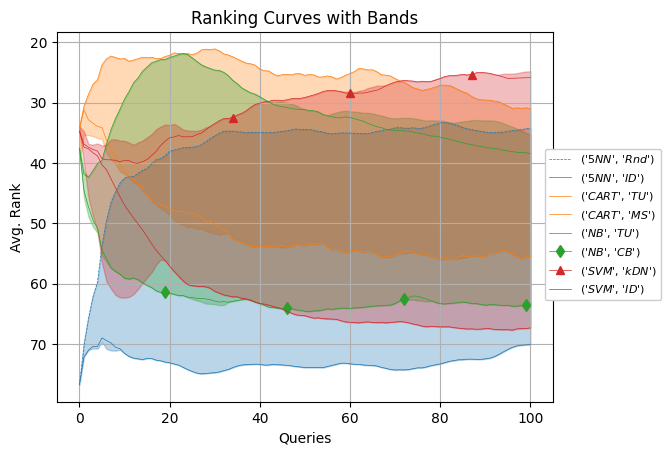

In [17]:
plot_ranking_curves_with_bands(avg_ranks_df)

### Analisando Bandas

In [18]:
def plot_learning_curves(avg_ranks_df, classifier):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_title(classifier)
    ax.set_xlabel("Queries")
    ax.set_ylabel("Avg. Ranks")
    

    # Calcula rank médio por query para cada 
    clf_ranks = avg_ranks_df.loc[classifier]
    auc_scores = {}
    for method, data in clf_ranks.groupby("method", sort=False):

        # aplica média móvel nos dados:
        smoothed_data = data.rolling(window=5, min_periods=1).mean()

        auc_scores[utils.ABREV_DICT[method]] = np.trapz(smoothed_data)
        
        ax.plot(smoothed_data.values, utils.get_style(method),
                label=utils.ABREV_DICT.get(method), color=COLOR_DICT[method], markevery=(0.3, 0.2),
                linewidth=(0.5 if utils.get_hm_type(method) != 'Classic' else 1.5) )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}

    sorted_labels = sorted(auc_scores, key=auc_scores.get)
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    plt.show()

In [19]:
w.interact(plot_learning_curves,
           avg_ranks_df=w.fixed(avg_ranks_df),
           classifier=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), description="Leaner:"))

interactive(children=(ToggleButtons(description='Leaner:', options=('GaussianNB', 'SVC', 'DecisionTree', '5NN'…

<function __main__.plot_learning_curves(avg_ranks_df, classifier)>

### Compartamento de grupo de medidas por banda

In [20]:
def plot_group_bands(avg_ranks, ax, title=None):

    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby("method").transform( lambda x: x.rolling(window=5, min_periods=1).mean())
    
    df = smoothed_ranks.reset_index()
    df['group'] = df.method.apply(utils.get_hm_type)
    
    color_list = sns.color_palette(cc.glasbey_dark, n_colors=df['group'].nunique())
    i=0
    
    for group, data in df.groupby("group"):

        color = color_list[i]
        i+=1
        
        if group == 'Classic':
                
            continue
            

        min_ranks = data.groupby("query")["rank"].min()
        max_ranks = data.groupby("query")["rank"].max()
        
        ax.plot(max_ranks, color=color)
        ax.plot(min_ranks, color=color)
        ax.fill_between(np.arange(len(min_ranks)), min_ranks, max_ranks,
                        alpha=0.3,color=color, label=group,
                        hatch=utils.get_hm_hatch(group))

    for method, scores in df[df['group'] == 'Classic'].groupby("method", sort=False):
            ax.plot(scores["rank"].values, ':', linewidth=1,
                    label=utils.ABREV_DICT[method], color=COLOR_DICT[method])
       

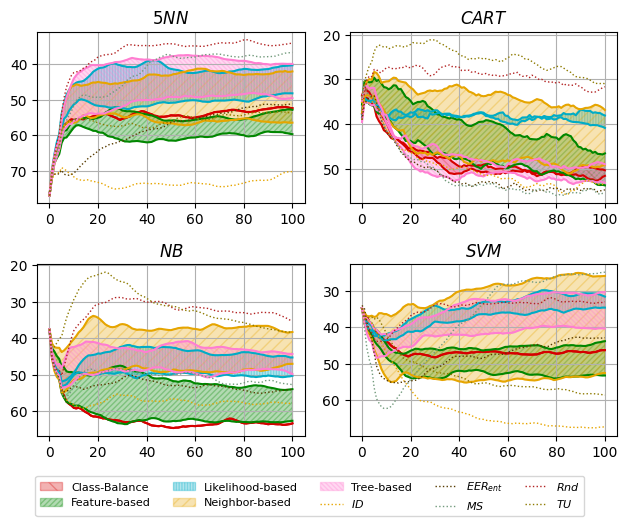

In [21]:
fig, axs = plt.subplots(2, 2)
for ax, clf in zip(axs.flatten(), sorted(utils.ABREV_MODEL.keys())):
    plot_group_bands(avg_ranks_df[clf], ax, title=utils.ABREV_MODEL[clf])
fig.tight_layout()
plt.legend(loc="lower center",bbox_to_anchor=(-0.15,-0.5),ncol=5, prop={'size': 8})

# Analisando desempenho por AULC

Instalação de módulo para ajudar com as análises de ranks

In [22]:
!pip install -q autorank

In [23]:
from autorank import autorank

Calcula a área embaixo da curva de aprendizado média para cada tupla `(classifier, dataset, method)`:

In [24]:
auc_scores = results_df.groupby(["classifier", "dataset", "method", "fold"]).kappa.apply(np.trapz).groupby(["classifier", "dataset", "method"]).mean()
auc_df = auc_scores.to_frame(name="AULC").reset_index().pivot(index=["classifier","dataset" ], columns="method", values="AULC")
auc_df = auc_df.unstack(level='classifier')

In [25]:
auc_df.head()

method                              borderline_points_sampling               \
classifier                                                 5NN DecisionTree   
dataset                                                                       
abalone-3class                                       24.258985    26.373291   
artificial-characters                                 2.883733     7.591667   
autoUniv-au1-1000                                     2.675763     2.860910   
autoUniv-au6-cd1-400                                 -0.470320     2.604652   
autoUniv-au7-300-drift-au7-cpd1-800                   2.099538     2.944098   

method                                                     \
classifier                          GaussianNB        SVC   
dataset                                                     
abalone-3class                       17.803102  25.541937   
artificial-characters                 2.709635  10.337590   
autoUniv-au1-1000                     6.933568   1.417851   
autoUniv-au6-cd1-400                  0.123423   0.082194   
autoUniv-au7-300-drift-au7-cpd1-800   4.305482   2.822024   

method                              class_balance_sampling               \
classifier                                             5NN DecisionTree   
dataset                                                                   
abalone-3class                                   29.379646    22.419141   
artificial-characters                             6.599016    11.153378   
autoUniv-au1-1000                                 3.037247     3.989961   
autoUniv-au6-cd1-400                              1.348907     0.400419   
autoUniv-au7-300-drift-au7-cpd1-800               4.325931     3.359209   

method                                                     \
classifier                          GaussianNB        SVC   
dataset                                                     
abalone-3class                       22.278977  31.449529   
artificial-characters                 2.015584  11.526686   
autoUniv-au1-1000                     0.407613   1.454447   
autoUniv-au6-cd1-400                  0.729663  -0.307662   
autoUniv-au7-300-drift-au7-cpd1-800   1.741325   2.787096   

method                              class_likelihood_sampling               \
classifier                                                5NN DecisionTree   
dataset                                                                      
abalone-3class                                      30.967617    28.139462   
artificial-characters                               15.036733    14.679780   
autoUniv-au1-1000                                    4.450783     2.617469   
autoUniv-au6-cd1-400                                 0.272161     1.554567   
autoUniv-au7-300-drift-au7-cpd1-800                  4.525581     3.771641   

method                               ... training_utility_sampling             \
classifier                           ...                GaussianNB        SVC   
dataset                              ...                                        
abalone-3class                       ...                 32.908472  29.991250   
artificial-characters                ...                 15.308543   7.446542   
autoUniv-au1-1000                    ...                 10.005404   5.482177   
autoUniv-au6-cd1-400                 ...                  1.816423  -0.815914   
autoUniv-au7-300-drift-au7-cpd1-800  ...                  6.325060   2.810963   

method                              tree_depth_pruned_sampling               \
classifier                                                 5NN DecisionTree   
dataset                                                                       
abalone-3class                                       29.750749    25.622270   
artificial-characters                                 7.625162     9.363161   
autoUniv-au1-1000                                     4.787784     2.594577   
autoUniv-au6-cd1-400                    

### Teste de Friedman

Aqui será utilizado o Teste de Friedman para responder as seguintes perguntas:
1. Existe alguma diferença estatistica nos resultados apresentados por todos os pares `(método, algoritmo)` nos conjuntos de dados?
2. Dado um algoritmo fixo $a$, a tecnica de aprendizado ativo que foi utilizada nos experimentos, fez alguma diferença estatísitca?

In [26]:
def apply_friedman_tests(observations :pd.DataFrame, alpha=.05) -> pd.DataFrame:
    
    N, M = observations.shape

    observation_list = [observation for _, observation in observations.items()]
    chisquare_result = stats.friedmanchisquare(*observation_list)
    chi_stat = chisquare_result.statistic
    chi_pvalue = chisquare_result.pvalue

    # Utiliza o chi quadrado do friedman para derivar a estatísica menos conservadora de Iman e Davenport (1980)
    F_stat = ((N-1)*chi_stat)/(N*(M-1) - chi_stat)

    ## Graus de liberdade da distribuição F que distribui a F_stat no teste acima
    dfn = M - 1
    dfd = (M-1)*(N-1)
    F_pvalue = stats.f.sf(F_stat, dfn, dfd)

    index = ["$\chi^2_F$", "$F_F$"]

    df =  pd.DataFrame({"Static Value": [chi_stat, F_stat], "$p$ value": [chi_pvalue, F_pvalue]}, index=index)
    
    color_function = lambda x: f'background-color: {"red" if x >= alpha else "green"}'
    
    return df.style.applymap(color_function, subset=["$p$ value"]).set_caption(fr"Friedman Test ($\alpha={alpha}$)")

#### Pergunta 1

Aqui fica evidente que **existe uma diferença estatística** na escolha do par `(método, algoritmo)` que é feita. O que não é uma grande surpresa, visto que a análise geral das curvas de ranking mostraram que há uma diferença clara de de desempenho entre os algoritmos.

In [27]:
apply_friedman_tests(auc_df)

,Static Value,$p$ value
$\chi^2_F$,1208.722430,0.000000
$F_F$,15.409256,0.000000


#### Pergunta 2

In [28]:
def responde_pergunta_2(scores_df, clf):
    clf_df = scores_df.iloc[:, scores_df.columns.get_level_values("classifier")==clf]
    return apply_friedman_tests(clf_df)

Aqui também também podemos perceber que existe diferença no método de aprendizado ativo escolhido para um determinado algoritmo de aprendizado **fixo**, o que indica que pelos menos um grupo de métodos foi pior/melhor que o esperado.

In [29]:
w.interact(responde_pergunta_2, scores_df = w.fixed(auc_df), clf=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), description="Classificador:"))

interactive(children=(ToggleButtons(description='Classificador:', options=('GaussianNB', 'SVC', 'DecisionTree'…

<function __main__.responde_pergunta_2(scores_df, clf)>

### Teste de Nemenyi

Os resultados dos teste de cima, permitem com que seja realizado o teste *post-hoc* de Nemenyi, para determinar se conseguimos detectar a diferença estatística entre algumas observações.

#### Análise Geral

In [30]:
general_results = autorank(auc_df)

In [31]:
auc_rank_df = general_results.rankdf[['meanrank']].reset_index()
auc_rank_df = auc_rank_df.sort_values(by="meanrank").sort_values(by='meanrank').reset_index(drop=True)

best_index = auc_rank_df.groupby("classifier").meanrank.idxmin().values
worst_index = auc_rank_df.groupby("classifier").meanrank.idxmax().values
rnd_index =  auc_rank_df[auc_rank_df.method == 'random_sampling'].index

In [32]:
def pretty_rank_table(styler):

    colnames = {'meanrank' : 'Avg. Rank' }
    
    def highlight_scores(col):
        return ['background-color: green' if idx in best_index
                else 'background-color: red' if idx in worst_index
                else 'background-color:  gray' if idx in rnd_index 
                else ''
                for idx in col.index]

    styler.set_caption("Avg. Ranks Table")
    styler.apply(highlight_scores)
    styler.format(lambda x: utils.ABREV_DICT[x], subset=['method'])
    styler.format(lambda x: utils.ABREV_MODEL[x], subset='classifier')

    return styler

In [33]:
auc_rank_df.style.pipe(pretty_rank_table)

,method,classifier,meanrank
0,$TU$,$CART$,21.255556
1,$Rnd$,$CART$,25.733333
2,$kDN$,$SVM$,27.727778
3,$TU$,$NB$,28.866667
4,$LSR$,$CART$,30.944444
5,$LSR$,$SVM$,31.027778
6,$Rnd$,$NB$,31.522222
7,$TD_U$,$SVM$,31.755556
8,$CLD$,$SVM$,32.122222
9,$Rnd$,$SVM$,33.522222


Salvando tabela em arquivo `.tex`

In [34]:
with open('table.tex', 'w') as f:
    latex_content = auc_rank_df.sort_values(by='meanrank').to_latex()
    f.write(latex_content)

In [35]:
selected_pairs = auc_rank_df.iloc[ np.unique(np.concatenate([best_index, worst_index, rnd_index]))]
selected_pairs.style.pipe(pretty_rank_table)

,method,classifier,meanrank
0,$TU$,$CART$,21.255556
1,$Rnd$,$CART$,25.733333
2,$kDN$,$SVM$,27.727778
3,$TU$,$NB$,28.866667
6,$Rnd$,$NB$,31.522222
9,$Rnd$,$SVM$,33.522222
12,$Rnd$,$5NN$,34.888889
70,$MS$,$CART$,52.933333
88,$ID$,$SVM$,65.044444
89,$CB$,$NB$,65.411111


In [57]:
nemenyi_df = auc_df.copy()
nemenyi_df.columns = nemenyi_df.columns.map('-'.join)
nemenyi_df = sp.posthoc_nemenyi_friedman(nemenyi_df)

selected_index = selected_pairs.method + '-' + selected_pairs.classifier
general_nemenyi = nemenyi_df.loc[selected_index, selected_index]

linhas, colunas = np.tril_indices_from(general_nemenyi, k=-1)
general_nemenyi.values[linhas, colunas] = 1

In [55]:
def show_nemenyi_table(styler):
    def format_names(x):
        res = x.split('-')
        method = res[0]
        classifier = res[1] if len(res) > 1 else ''

        final = f'{utils.ABREV_DICT[method].strip()}'
        
        if classifier:
            final+=f'+{utils.ABREV_MODEL[classifier]}'
            
        return final

    def color_index(s):
        return ["background-color: darkblue" if utils.get_hm_type(x.split('-')[0]) != 'Classic' else "" for x in s] 
    
    def color_cells(s):
        return ['color: green' if x <=0.01 
                else 'color: lightgreen' if x <= 0.05
                else 'color: orange' if x <= .1
                else 'color: red' if x>=1
                else ''
                for x in s]
        
    def format_significance(val):
        if val <= 0.01:
            return '*'
        elif val <= 0.05:
            return '+'
        elif val <=0.1:
            return '.'
        else:
            return ''
            

    styler.apply_index(color_index, axis=0)
    styler.apply_index(color_index, axis=1)
    styler.format_index(format_names, axis=0)
    styler.format_index(format_names, axis=1)
    # styler.apply(color_cells, axis=1)
    styler.format(format_significance)
    styler.set_properties(**{'text-align': 'center'})


    return styler
    
    

In [58]:
general_nemenyi.style.pipe(show_nemenyi_table)

,$TU$+$CART$,$Rnd$+$CART$,$kDN$+$SVM$,$TU$+$NB$,$Rnd$+$NB$,$Rnd$+$SVM$,$Rnd$+$5NN$,$MS$+$CART$,$ID$+$SVM$,$CB$+$NB$,$ID$+$5NN$
$TU$+$CART$,,,,,,,,*,*,*,*
$Rnd$+$CART$,,,,,,,,*,*,*,*
$kDN$+$SVM$,,,,,,,,*,*,*,*
$TU$+$NB$,,,,,,,,*,*,*,*
$Rnd$+$NB$,,,,,,,,*,*,*,*
$Rnd$+$SVM$,,,,,,,,*,*,*,*
$Rnd$+$5NN$,,,,,,,,+,*,*,*
$MS$+$CART$,,,,,,,,,,,*
$ID$+$SVM$,,,,,,,,,,,
$CB$+$NB$,,,,,,,,,,,


#### Análise por classificador

In [39]:
auc_rank_df[auc_rank_df.classifier == "5NN"].sort_values(by="meanrank").method.values.shape

(23,)

In [56]:
def apply_nemenyi(clf):
    df = sp.posthoc_nemenyi_friedman(auc_df.iloc[:, auc_df.columns.get_level_values("classifier")==clf])
    
    sorted_index = auc_rank_df[auc_rank_df.classifier == clf].sort_values(by="meanrank").method.values

    # mask = df < 0.05
    # resultados = {row: mask.columns[mask.loc[row]].tolist() for row in df.index }
    # resultados = {k: ', '.join(map(utils.ABREV_DICT.get, vs)) for k, vs in resultados.items()}
    # return pd.Series(resultados).to_frame().style.format_index(utils.ABREV_DICT.get)

    df = df.loc[sorted_index, sorted_index]
    
    linhas, colunas = np.tril_indices_from(df, k=-1)

    df.values[linhas, colunas] = 1
    
    return df.style.pipe(show_nemenyi_table).set_caption(f"One versus one ({utils.ABREV_MODEL[clf]})")

w.interact(apply_nemenyi,
           clf=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), description="Classificador:"))

interactive(children=(ToggleButtons(description='Classificador:', options=('GaussianNB', 'SVC', 'DecisionTree'…

<function __main__.apply_nemenyi(clf)>

<IPython.core.display.Latex object>